In [1]:
import sys
from pathlib import Path

# Add the 'backtest' directory to the system path
notebook_dir = Path().resolve()
backtest_dir = notebook_dir.parent / 'backtest'
sys.path.append(str(backtest_dir))

In [2]:
import pandas as pd
from backtest import Backtest, Strategy, TradeAction

In [3]:
# First run the get_data.ipynb notebook to generate the data file
# or use the code from get_data.ipynb here to download the data directly

# Read the OHLCV data from data/BTCUSDT.csv
# Use small subset of data for easier analysis
data = pd.read_csv('data/BTCUSDT.csv', index_col='Date', parse_dates=True).loc['2025-01-01':]

In [ ]:
class BuyOnDateStrategy(Strategy):
    """
    A strategy that buys on a specific date and sells after a certain number of days.
    """

    def __init__(self):
        self.buy_date = pd.Timestamp("2025-02-01")
        self.sell_date = pd.Timestamp("2025-03-01")

    def on_candle(self, historical_data, positions_list):
        if historical_data.index[-1] == pd.to_datetime("2025-02-01"):
            return [TradeAction(action="enter", value=10000)]
        elif historical_data.index[-1] == pd.to_datetime("2025-03-01"):
            open_positions = [p for p in positions_list if p.exit_time is None]
            return [
                TradeAction(action="exit", position_id=pos.id) for pos in open_positions
            ]
        return []

In [16]:
backtest = Backtest(data, BuyOnDateStrategy)

backtest.run()

backtest.pnl_df

Opening position: 0.09936835511388309 units
Closing position: 1


,Open,High,Low,Close,Volume,pos-1-pnl,total_pnl
Date,,,,,,,
2025-01-01,93576.00,95151.15,92888.00,94591.79,10373.32613,0.000000,0.000000
2025-01-02,94591.78,97839.50,94392.00,96984.79,21970.48948,0.000000,0.000000
2025-01-03,96984.79,98976.91,96100.01,98174.18,15253.82936,0.000000,0.000000
2025-01-04,98174.17,98778.43,97514.79,98220.50,8990.05651,0.000000,0.000000
2025-01-05,98220.51,98836.85,97276.79,98363.61,8095.63723,0.000000,0.000000
...,...,...,...,...,...,...,...
2025-04-09,76322.42,83588.00,74620.00,82615.22,75488.28772,-1447.908227,-1447.908227
2025-04-10,82615.22,82753.21,78464.36,79607.30,33284.80718,-1447.908227,-1447.908227
2025-04-11,79607.30,84300.00,78969.58,83423.84,34435.43797,-1447.908227,-1447.908227


In [17]:
stats = backtest.stats()

Backtest Statistics:
total_return: -1447.9082265670058
max_drawdown: -1697.0554970275953
sharpe_ratio: -0.1373797382507362
num_trades: 1
win_rate: 0.0
avg_win: 0.0
avg_loss: -1447.9082265670052


In [ ]:
# Create a series with indices as entry dates and "Open" prices from backtest.pnl_df
entry_series = backtest.pnl_df.loc[[pos.entry_time for pos in backtest.positions], 'Open']

# Create a series with indices as exit dates and "Open" prices from backtest.pnl_df
exit_series = backtest.pnl_df.loc[[pos.exit_time for pos in backtest.positions], 'Open']


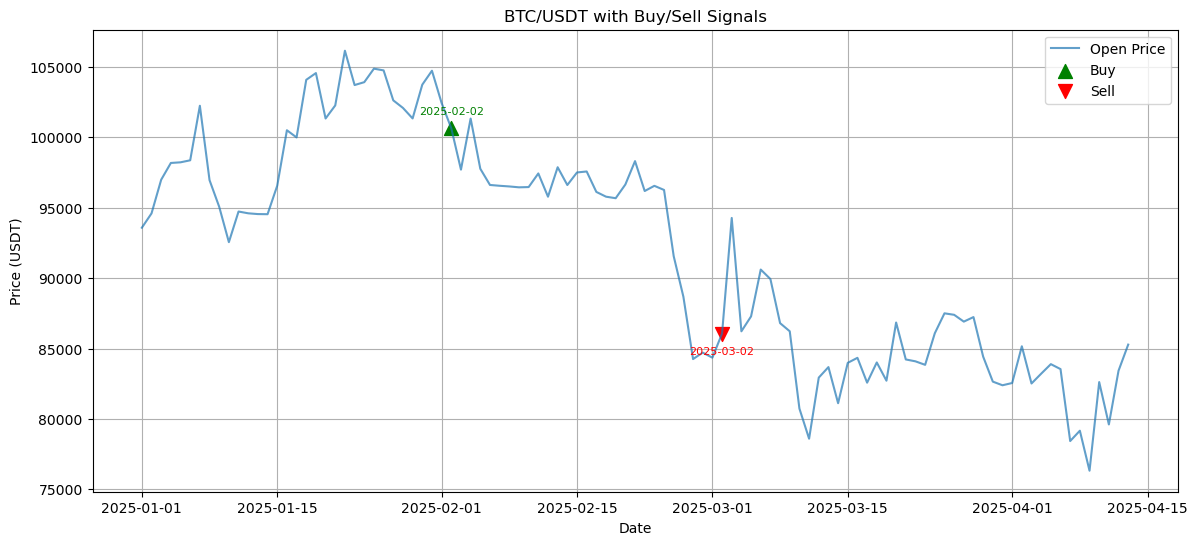

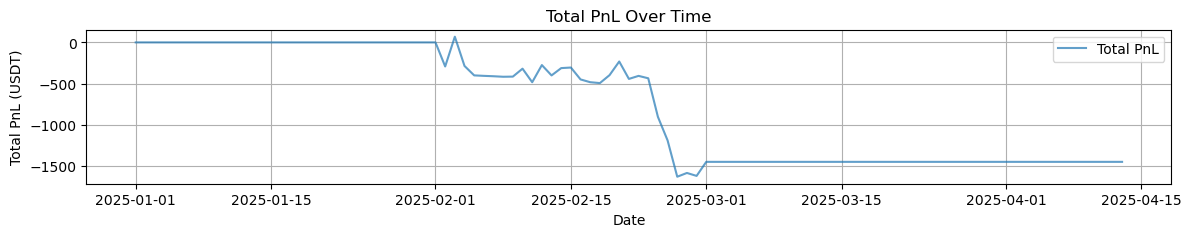

In [28]:
from matplotlib import pyplot as plt

df = backtest.pnl_df

plt.figure(figsize=(14, 6))
plt.plot(df['Open'], label="Open Price", alpha=0.7)

plt.scatter(entry_series.index, entry_series, marker='^', color="green", label="Buy", s=100)

plt.scatter(exit_series.index, exit_series, marker='v', color="red", label="Sell", s=100)

for idx, price in entry_series.items():
    plt.annotate(idx.strftime('%Y-%m-%d'), xy=(idx, price), xytext=(0, 10), 
                 textcoords='offset points', ha='center', fontsize=8, color='green')
    
for idx, price in exit_series.items():
    plt.annotate(idx.strftime('%Y-%m-%d'), xy=(idx, price), xytext=(0, -15), 
                 textcoords='offset points', ha='center', fontsize=8, color='red')

plt.title("BTC/USDT with Buy/Sell Signals")
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the Total PnL
plt.figure(figsize=(14, 2))
plt.plot(df['total_pnl'], label="Total PnL", alpha=0.7)
plt.title("Total PnL Over Time")
plt.xlabel('Date')
plt.ylabel('Total PnL (USDT)')
plt.legend()
plt.grid(True)
plt.show()